In [392]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dataframe_image as dfi

import gensim #the library for Topic modelling

from gensim.models.ldamulticore import LdaMulticore

from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer


In [393]:
from main_function import clean_data

In [394]:
xl = "C:\\Users\\zachi\\Desktop\\final_project_22\\data_nov_21.xlsx"

#month = 'November'


first_day = '2021-11-1'
last_day = '2021-11-30'

new_df = clean_data (xl,first_day,last_day)


c:\Users\zachi\FOA-TAU-Data-analysis-project\inner organization report\main_function.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  posts_description=posts_description.str.lower().str.replace('[^\w\s]','')


In [395]:
import numpy as np
set = new_df["Platform"].value_counts()
array = set.values
array = array.tolist()


Analyze content type by date range & platform

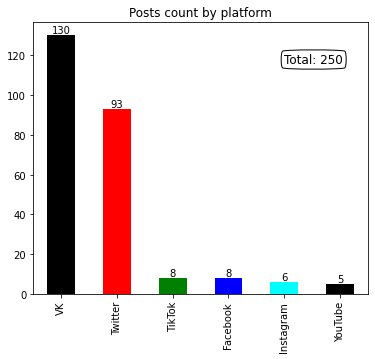

In [396]:
# Count posts for each platform in the data set



posts_in_platforms = set.plot(kind="bar",color=['black', 'red', 'green', 'blue', 'cyan'],title = "Posts count by platform",figsize = (6,5))

posts_in_platforms.get_yaxis().set_visible(True)


plt.annotate("Total:" + " " + str(sum(set)), xy=(0.75, 0.85), xycoords='axes fraction', size = 12, bbox=dict(boxstyle="round4", fc="w"))

posts_in_platforms.bar_label(posts_in_platforms.containers[0], label_type='edge')



plt.savefig("posts_in_platforms.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


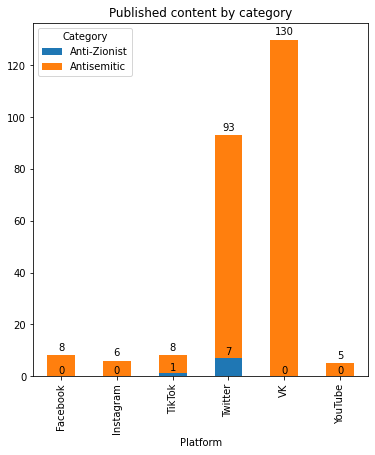

In [397]:
#Mapping the category type through the platforms

df_group_=new_df.groupby(['Category', 'Platform'])['Platform'].count().unstack('Category').fillna(0).astype(int)
categories_per_each_platform = df_group_.plot(kind='bar', stacked=True,mark_right = True ,title = "Published content by category",figsize = (6,6.5))

categories_per_each_platform.bar_label(categories_per_each_platform.containers[1], label_type='edge',padding=3)
categories_per_each_platform.bar_label(categories_per_each_platform.containers[0], label_type='edge',padding=1)

plt.savefig("categories_per_each_platform.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.9,
        facecolor='auto', edgecolor='auto',
        backend=None)

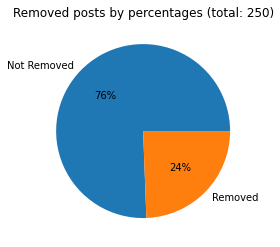

In [398]:
#Cheking the percentage of posts removing in general view

status = new_df["Removed"]

#df.groupby("Category").agg({status:"mean"})

# category = df["Category"] ###### /\


general_removal_view = status.value_counts() #get general info about the removal process of platforms

general_removal_view_plot = general_removal_view.plot(kind = "pie" , autopct='%1.0f%%', title = "Removed posts by percentages (total:" + " "+ str(sum(set))+ ")", textprops={'color':"black"}) 

general_removal_view_plot.get_yaxis().set_visible(False)


plt.savefig("general_removal_view_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

Content removal data (by category)

In [399]:
new_df.groupby(['Category', 'Removed'])['Removed'].count().unstack('Removed').fillna(0).astype(int)

#This function is grouping the DF by the removal status & the category
outpot_category_removal_stats= new_df.groupby(['Removed', 'Category'])['Category'].count().unstack('Category').fillna(0).astype(int).reindex(index = ['Removed','Not Removed']).astype("int")

In [400]:
#Saving the counting chart as a picture

dfi.export(outpot_category_removal_stats,"outpot_category_removal_stats_plot.png")


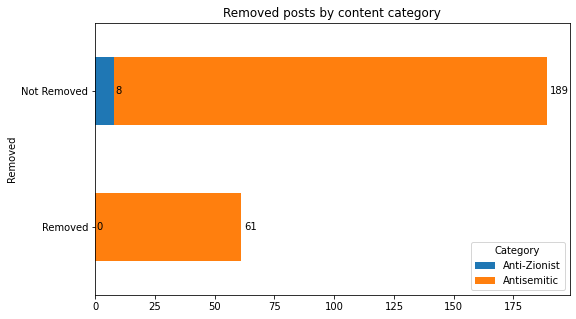

In [401]:
outpot_category_removal_stats_plot = outpot_category_removal_stats.plot(kind='barh', stacked=True,mark_right = True, title = "Removed posts by content category", figsize = (8.5,5) )

outpot_category_removal_stats_plot.get_yaxis().set_visible(True)

outpot_category_removal_stats_plot.bar_label(outpot_category_removal_stats_plot.containers[1], label_type='edge',padding=3)
outpot_category_removal_stats_plot.bar_label(outpot_category_removal_stats_plot.containers[0], label_type='edge',padding=1)


plt.savefig("outpot_category_removal_stats_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


Content removal data (by platform)

In [402]:
#Gropping the data by removal status + platform and plot a percentage summary of the data

outpot_category_removal_stats_by_platform= new_df.groupby(['Removed', 'Platform'])['Platform'].count().unstack('Platform').fillna(0).astype(int).reindex(index = ['Removed','Not Removed'])

precentage_chart = outpot_category_removal_stats_by_platform/outpot_category_removal_stats_by_platform[outpot_category_removal_stats_by_platform.columns].sum()*100

precentage_chart_plot = precentage_chart.round(1).astype(str) +'%'

dfi.export(precentage_chart_plot,"precentage_chart_plot.png")



In [403]:
outpot_category_removal_stats_by_platform

dfi.export(outpot_category_removal_stats_by_platform, "num_chart_plot.png")

Text analysis - find central keywords in the provided posts


In [404]:
#Make a new DF which focusing on removed posts only 

only_removed_content = new_df["Removed"]!="Not Removed"
only_removed_content = new_df[only_removed_content]

#Cleaning text symbols and make it all letters lower case

removed_posts_description = only_removed_content["A short summary of the content- write briefly in your own words "]


In [405]:
#Use this only if nltk package donwloding needed

import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

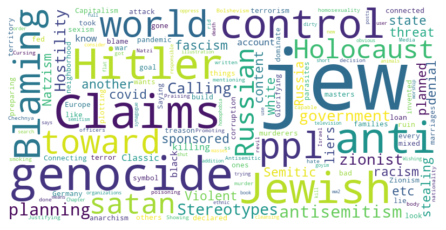

In [406]:
#Finding the most popular keywords in the removed content 

stop = stopwords.words('english')
new_list=["picture","video","pic","cartoon","photo","int","dtype","Claiming","claiming","non","dtype","int64"," int64 ",  "int64 ",  " int64","dtype: int64"]
stop.extend(new_list)


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


text = " ".join(word for word in removed_posts_description.astype(str))
wordcloud = WordCloud(stopwords=stop, background_color="white", width=800, height=400).generate(text)

plt.axis("off")


plt.tight_layout(pad=0)

plt.imshow(wordcloud, interpolation='bilinear')


plt.savefig("wordcloud_new.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [407]:
#A full pdf report extraction

from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF

pdf = FPDF()

pdf.add_page()

pdf.set_margins(0, 0, 0)


pdf.set_font('Arial', 'b', size = 24)


pdf.cell(80, 20,'Inner report: '+ " " +  first_day + " "+ "|" + " " + last_day, 0, 1, ' ')

pdf.ln(50)
pdf.cell(30)

pdf.image("posts_in_platforms.png", x = 35, y = 50, w = 120, h = 100, type = '', link = '')


pdf.ln(40)

pdf.image("categories_per_each_platform.png", x = 28, y = 150, w = 150, h = 150, type = '', link = '')

pdf.add_page()


pdf.image("general_removal_view_plot.png", x = 50, y = 20 , w = 100, h = 100, type = '', link = '')


pdf.image("outpot_category_removal_stats_plot.png" ,x = 23, y = 140, w = 170, h = 120, type = '', link = '')

pdf.add_page()

pdf.image("precentage_chart_plot.png", x = 50, y = 20 , w = 110, h = 48, type = '', link = '')

pdf.image("num_chart_plot.png",x = 50, y = 110, w = 104, h = 42, type = '', link = '')



pdf.image("wordcloud_new.png",x = 38, y = 185, w = 150, h = 80, type = '', link = '')



pdf.output("Inner report.pdf")

os.startfile("Inner report.pdf")
